<h2><center>ProdClassify</h2>


### Project Summary

This project focuses on categorizing e-commerce products into one of four predefined groups—`Electronics`, `Household`, `Books`, and `Clothing & Accessories`—based solely on the textual descriptions provided on e-commerce platforms. The notebook walks through the following major steps:

- Started with basic [**exploratory data analysis (EDA)**](https://en.wikipedia.org/wiki/Exploratory_data_analysis) by examining how product descriptions differ across categories in terms of character count, word count, and average word length.
- Applied various [**text preprocessing and normalization**](https://en.wikipedia.org/wiki/Text_normalization) methods to clean and prepare the product descriptions for modeling.
- Utilized the [**TF-IDF**](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) approach to convert the cleaned text data into numerical features, tested out multiple classification models, and fine-tuned a [**Support Vector Machine (SVM)**](https://en.wikipedia.org/wiki/Support-vector_machine) with a linear kernel to optimize performance.
- In a parallel approach, used minimal normalization (like converting to lowercase and replacing [**contractions**](https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions)), then generated word embeddings using [**Google’s pre-trained Word2Vec**](https://en.wikipedia.org/wiki/Word2vec) model. These embeddings were transformed into [**Compressed Sparse Row (CSR)**](https://en.wikipedia.org/wiki/Sparse_matrix) format before being fed into several classifiers. We further fine-tuned an [**XGBoost**](https://en.wikipedia.org/wiki/XGBoost) classifier to boost accuracy.
- Finally, the best-performing model was used to predict labels for the test dataset, achieving an accuracy score of **0.940669**.


### Importing libraries

In [ ]:
# !pip install numpy --upgrade --force-reinstall
# !pip install gensim --upgrade --force-reinstall
# File system manangement
import time, psutil, os

# Data manipulation
import numpy as np
import pandas as pd

# Plotting and visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_theme()
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# NLP
import string, re, nltk
from string import punctuation
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
!pip install num2words
from num2words import num2words
!pip install pyspellchecker
from spellchecker import SpellChecker
from nltk.stem.porter import PorterStemmer
import spacy
from nltk.stem import WordNetLemmatizer

# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Scipy
import scipy
from scipy import sparse
from scipy.sparse import csr_matrix

# Train-test split and cross validation
from sklearn.model_selection import train_test_split, ParameterGrid

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

# Model evaluation
from sklearn import metrics
from sklearn.metrics import accuracy_score

# Others
import json
!pip install gensim
import gensim
from sklearn.decomposition import TruncatedSVD

### Runtime and memory usage

In [ ]:
# Recording the starting time, complemented with a stopping time check in the end to compute process runtime
start = time.time()

# Class representing the OS process and having memory_info() method to compute process memory usage
process = psutil.Process(os.getpid())

## Introduction

### E-commerce Product Categorization

**E-commerce** refers to buying and selling goods or services over the Internet, often through web-based platforms or apps. Common transactions include purchasing physical items (e.g., books, electronics) or digital services (e.g., music downloads). It includes areas like online retail, electronic marketplaces, and online auctions, all aimed at providing fast and convenient shopping experiences.

**Product categorization** is the process of organizing items into predefined categories, helping users easily navigate and find products. While building a product catalog structure usually needs manual input, machine learning can automate the **tagging of products** based on their descriptions—a time-consuming task when done manually. In this notebook, we aim to automatically assign product categories like `Electronics`, `Household`, `Books`, and `Clothing & Accessories` using product descriptions. This enhances both user experience and search functionality.

### Text Classification

**Text classification** is a core task in natural language processing where a piece of text is labeled with a relevant category. It's widely used in applications like spam filtering, sentiment analysis, news categorization, and customer support tagging.

In this project, product descriptions serve as the input text, and the goal is to classify them into one of the four product categories mentioned above.

### Data

- **Original source:** [https://doi.org/10.5281/zenodo.3355823](https://doi.org/10.5281/zenodo.3355823)  
- **Kaggle dataset:** [https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification](https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification)

The dataset, scraped from Indian e-commerce platforms, consists of product descriptions from four broad categories—`Electronics`, `Household`, `Books`, and `Clothing & Accessories`—which together represent a large portion of typical online catalogs. It is provided in CSV format with two columns: one for the product description and another for its category. For convenience, the columns were reordered so the label appears on the right.

In [ ]:
# Loading and customizing the data
data = pd.read_csv(
    'https://raw.githubusercontent.com/shah-vraj/ProdClassify/master/ecommerceDataset.csv',
    names = ['label', 'description']
)
data = data[['description', 'label']]

print(pd.Series({"Memory usage": "{:.2f} MB".format(data.memory_usage().sum()/(1024*1024)),
                 "Dataset shape": "{}".format(data.shape)}).to_string())
data

Memory usage        0.77 MB
Dataset shape    (50425, 2)


,description,label
0,Paper Plane Design Framed Wall Hanging Motivat...,Household
1,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",Household
2,SAF 'UV Textured Modern Art Print Framed' Pain...,Household
3,"SAF Flower Print Framed Painting (Synthetic, 1...",Household
4,Incredible Gifts India Wooden Happy Birthday U...,Household
...,...,...
50420,Strontium MicroSD Class 10 8GB Memory Card (Bl...,Electronics
50421,CrossBeats Wave Waterproof Bluetooth Wireless ...,Electronics
50422,Karbonn Titanium Wind W4 (White) Karbonn Titan...,Electronics
50423,"Samsung Guru FM Plus (SM-B110E/D, Black) Colou...",Electronics


In [ ]:
# Dropping observations with missing values
data.dropna(inplace = True)

# Dropping duplicate observations
data.drop_duplicates(inplace = True)

# Resetting index
data.reset_index(drop = True, inplace = True)

The labels are manually encoded with the following scheme:
- **Electronics** $\mapsto$ $0$
- **Household** $\mapsto$ $1$
- **Books** $\mapsto$ $2$
- **Clothing & Accessories** $\mapsto$ $3$

In [ ]:
# Manual encoding of labels
label_dict = {'Electronics': 0, 'Household': 1, 'Books': 2, 'Clothing & Accessories': 3}
data.replace({'label': label_dict}, inplace = True)

print(pd.Series({"Memory usage": "{:.2f} MB".format(data.memory_usage().sum()/(1024*1024)),
                 "Dataset shape": "{}".format(data.shape)}).to_string())
data

<ipython-input-8-a613b7c43da4>:3: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Memory usage        0.42 MB
Dataset shape    (27802, 2)


,description,label
0,Paper Plane Design Framed Wall Hanging Motivat...,1
1,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",1
2,SAF 'UV Textured Modern Art Print Framed' Pain...,1
3,"SAF Flower Print Framed Painting (Synthetic, 1...",1
4,Incredible Gifts India Wooden Happy Birthday U...,1
...,...,...
27797,Micromax Bharat 5 Plus Zero impact on visual d...,0
27798,Microsoft Lumia 550 8GB 4G Black Microsoft lum...,0
27799,"Microsoft Lumia 535 (Black, 8GB) Colour:Black ...",0
27800,Karbonn Titanium Wind W4 (White) Karbonn Titan...,0


# Exploratory Data Analysis

We split the dataset based on the target classes, in order to see how different textual attributes vary across classes.

In [ ]:
# Splitting the dataset by label
data_e = data[data['label'] == 0] # Electronics
data_h = data[data['label'] == 1] # Household
data_b = data[data['label'] == 2] # Books
data_c = data[data['label'] == 3] # Clothing & Accessories

## Class Frequencies

In [ ]:
# Visualization of class frequencies
values = np.array([len(data_e), len(data_h), len(data_b), len(data_c)])
labels = ['Electronics', 'Household', 'Books', 'Clothing & Accessories']
fig = go.Figure(data = [go.Pie(values = values, labels = labels, hole = 0.5, textinfo = 'percent', title = " ")])
text_title = "Comparison of class frequencies"
fig.update_layout(height = 500, width = 800, showlegend = True, title = dict(text = text_title, x = 0.5, y = 0.95))
fig.show()

## Number of Characters

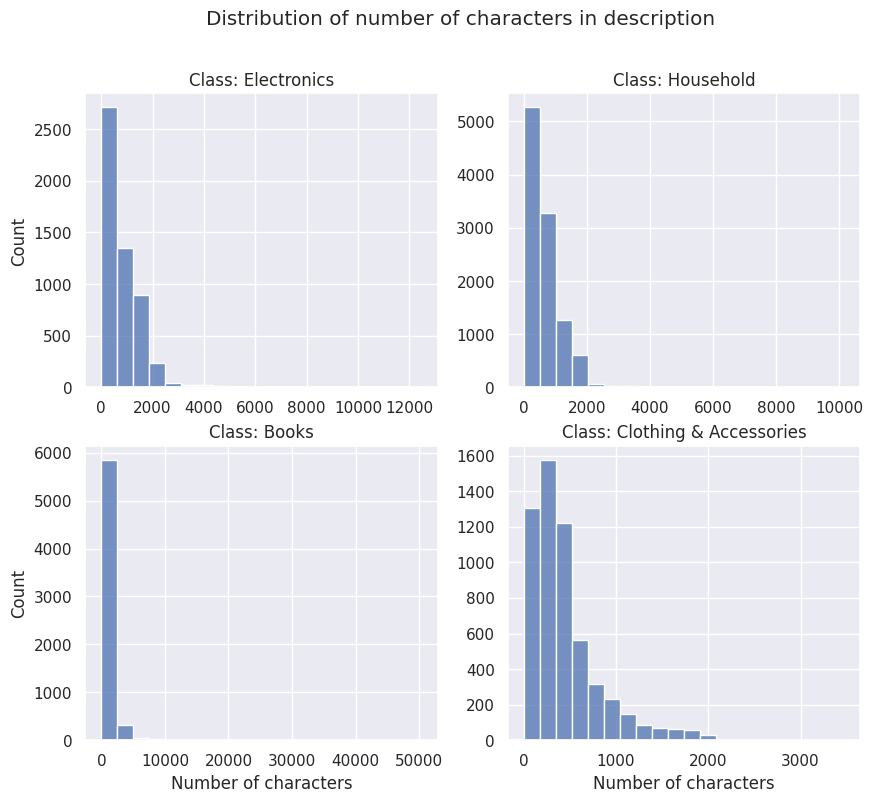

In [ ]:
# Distribution of number of characters in description
data_e_char = data_e['description'].str.len()
data_h_char = data_h['description'].str.len()
data_b_char = data_b['description'].str.len()
data_c_char = data_c['description'].str.len()

fig, ax = plt.subplots(2, 2, figsize = (10, 8.4), sharey = False)
sns.histplot(x = data_e_char, bins = 20, ax = ax[0, 0]).set_title('Class: Electronics')
sns.histplot(x = data_h_char, bins = 20, ax = ax[0, 1]).set_title('Class: Household')
sns.histplot(x = data_b_char, bins = 20, ax = ax[1, 0]).set_title('Class: Books')
sns.histplot(x = data_c_char, bins = 20, ax = ax[1, 1]).set_title('Class: Clothing & Accessories')

fig.suptitle("Distribution of number of characters in description")
for i in range(4):
    ax[i // 2, i % 2].set_xlabel(" ") if i // 2 == 0 else ax[i // 2, i % 2].set_xlabel("Number of characters")
    if i % 2 != 0: ax[i // 2, i % 2].set_ylabel(" ")

## Number of Words

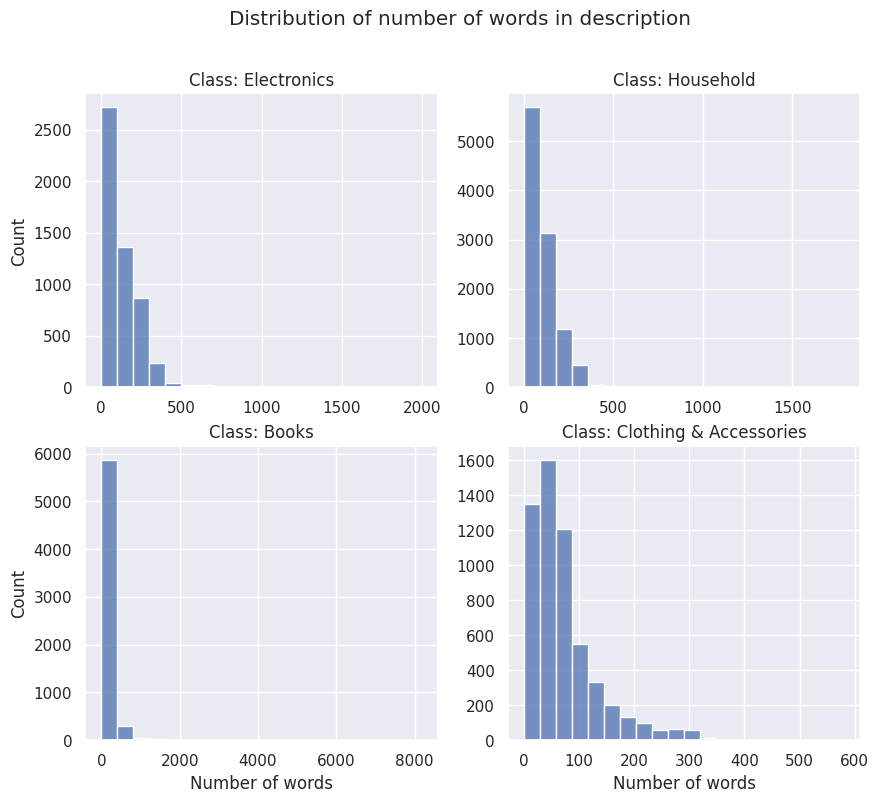

In [ ]:
# Distribution of number of words in description
data_e_word = data_e['description'].str.split().map(lambda x: len(x))
data_h_word = data_h['description'].str.split().map(lambda x: len(x))
data_b_word = data_b['description'].str.split().map(lambda x: len(x))
data_c_word = data_c['description'].str.split().map(lambda x: len(x))

fig, ax = plt.subplots(2, 2, figsize = (10, 8.4), sharey = False)
sns.histplot(x = data_e_word, bins = 20, ax = ax[0, 0]).set_title('Class: Electronics')
sns.histplot(x = data_h_word, bins = 20, ax = ax[0, 1]).set_title('Class: Household')
sns.histplot(x = data_b_word, bins = 20, ax = ax[1, 0]).set_title('Class: Books')
sns.histplot(x = data_c_word, bins = 20, ax = ax[1, 1]).set_title('Class: Clothing & Accessories')

fig.suptitle("Distribution of number of words in description")
for i in range(4):
    ax[i // 2, i % 2].set_xlabel(" ") if i // 2 == 0 else ax[i // 2, i % 2].set_xlabel("Number of words")
    if i % 2 != 0: ax[i // 2, i % 2].set_ylabel(" ")

## Average Word-length

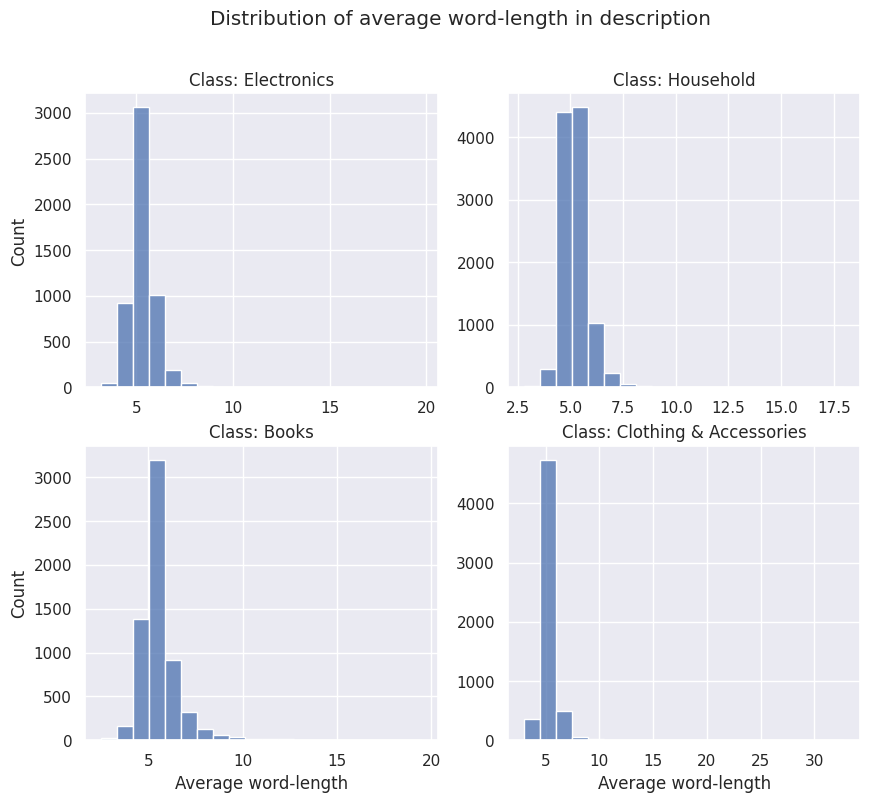

In [ ]:
# Distribution of average word-length in description
data_e_avg = data_e['description'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
data_h_avg = data_h['description'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
data_b_avg = data_b['description'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
data_c_avg = data_c['description'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))

fig, ax = plt.subplots(2, 2, figsize = (10, 8.4), sharey = False)
sns.histplot(x = data_e_avg, bins = 20, ax = ax[0, 0]).set_title('Class: Electronics')
sns.histplot(x = data_h_avg, bins = 20, ax = ax[0, 1]).set_title('Class: Household')
sns.histplot(x = data_b_avg, bins = 20, ax = ax[1, 0]).set_title('Class: Books')
sns.histplot(x = data_c_avg, bins = 20, ax = ax[1, 1]).set_title('Class: Clothing & Accessories')

fig.suptitle("Distribution of average word-length in description")
for i in range(4):
    ax[i // 2, i % 2].set_xlabel(" ") if i // 2 == 0 else ax[i // 2, i % 2].set_xlabel("Average word-length")
    if i % 2 != 0: ax[i // 2, i % 2].set_ylabel(" ")

# Train-Validation-Test Split

In [ ]:
# Feature-target split
X, y = data.drop('label', axis = 1), data['label']

# Train-test split (from complete data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 40)
data_train = pd.concat([X_train, y_train], axis = 1)

# Validation-test split (from test data)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 40)
data_val, data_test = pd.concat([X_val, y_val], axis = 1), pd.concat([X_test, y_test], axis = 1)

# Comparison of sizes of training set, validation set and test set
values = np.array([len(data_train), len(data_val), len(data_test)])
labels = ['Training set', 'Validation Set', 'Test set']
fig = go.Figure(data = [go.Pie(values = values, labels = labels, hole = 0.5, textinfo = 'percent', title = " ")])
text_title = "Comparison of sizes of training set, validation set and test set"
fig.update_layout(height = 500, width = 800, showlegend = True, title = dict(text = text_title, x = 0.5, y = 0.95))
fig.show()

# Text Normalization

In natural language processing, **text normalization** is the process of transforming text into a single canonical form. We consider a number of text normalization processes. At the end of the section, we combine selected processes into one single function and apply it on the product descriptions.

In [ ]:
# RegexpTokenizer
regexp = RegexpTokenizer("[\w']+")

## Convertion to Lowercase

Converts all characters to lowercase to avoid treating words like *Sun* and *sun* differently.

In [ ]:
# Converting to lowercase
def convert_to_lowercase(text):
    return text.lower()

text = "This is a FUNCTION that CoNvErTs a Text to lowercase"
print("Input: {}".format(text))
print("Output: {}".format(convert_to_lowercase(text)))

Input: This is a FUNCTION that CoNvErTs a Text to lowercase
Output: this is a function that converts a text to lowercase


## Removal of Whitespaces

Removes unnecessary empty spaces from the description of the observations.

In [ ]:
# Removing whitespaces
def remove_whitespace(text):
    return text.strip()

text = " \t This is a string \t "
print("Input: {}".format(text))
print("Output: {}".format(remove_whitespace(text)))

Input:  	 This is a string 	 
Output: This is a string


## Removal of Punctuations

Removes most punctuation to reduce noise, except for **apostrophes** which are useful in contractions.

In [ ]:
# Removing punctuations
def remove_punctuation(text):
    punct_str = string.punctuation
    # discarding apostrophe from the string to keep the contractions intact
    punct_str = punct_str.replace("'", "")
    return text.translate(str.maketrans("", "", punct_str))

text = "Here's [an] example? {of} &a string. with.? punctuations!!!!"
print("Input: {}".format(text))
print("Output: {}".format(remove_punctuation(text)))

Input: Here's [an] example? {of} &a string. with.? punctuations!!!!
Output: Here's an example of a string with punctuations


## Removal of Unicode Characters

Uses regex to strip out emojis, URLs, and special symbols that don't contribute meaningfully.

In [ ]:
# Removing HTML tags
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

text = '<a href = "https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification"> Ecommerce Text Classification </a>'
print("Input: {}".format(text))
print("Output: {}".format(remove_html(text)))

Input: <a href = "https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification"> Ecommerce Text Classification </a>
Output:  Ecommerce Text Classification 


In [ ]:
# Removing emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags = re.UNICODE)
    return emoji_pattern.sub(r'', text)

text = "This innovative hd printing technique results in durable and spectacular looking prints 😊"
print("Input: {}".format(text))
print("Output: {}".format(remove_emoji(text)))

Input: This innovative hd printing technique results in durable and spectacular looking prints 😊
Output: This innovative hd printing technique results in durable and spectacular looking prints 


In [ ]:
# Removing other unicode characters
def remove_http(text):
    http = "https?://\S+|www\.\S+" # matching strings beginning with http (but not just "http")
    pattern = r"({})".format(http) # creating pattern
    return re.sub(pattern, "", text)

text = "It's a function that removes links starting with http: or https such as https://en.wikipedia.org/wiki/Unicode_symbols"
print("Input: {}".format(text))
print("Output: {}".format(remove_http(text)))

Input: It's a function that removes links starting with http: or https such as https://en.wikipedia.org/wiki/Unicode_symbols
Output: It's a function that removes links starting with http: or https such as 


## Substitution of Acronyms

Replaces common acronyms like *fyi* or *btw* with their full forms for better clarity.

In [ ]:
# Dictionary of acronyms
acronyms_url = 'https://raw.githubusercontent.com/shah-vraj/ProdClassify/master/english_acronyms.json'
acronyms_dict = pd.read_json(acronyms_url, typ = 'series')

print("Example: Original form of the acronym 'fyi' is '{}'".format(acronyms_dict['fyi']))

Example: Original form of the acronym 'fyi' is 'for your information'


In [ ]:
# Dataframe of acronyms
pd.DataFrame(acronyms_dict.items(), columns = ['acronym', 'original']).head()

,acronym,original
0,aka,also known as
1,asap,as soon as possible
2,brb,be right back
3,btw,by the way
4,dob,date of birth


In [ ]:
# List of acronyms
acronyms_list = list(acronyms_dict.keys())

In [ ]:
# Function to convert contractions in a text
def convert_acronyms(text):
    words = []
    for word in regexp.tokenize(text):
        if word in acronyms_list:
            words = words + acronyms_dict[word].split()
        else:
            words = words + word.split()

    text_converted = " ".join(words)
    return text_converted

text = "btw you've to fill in the details including dob"
print("Input: {}".format(text))
print("Output: {}".format(convert_acronyms(text)))

Input: btw you've to fill in the details including dob
Output: by the way you've to fill in the details including date of birth


## Substitution of Contractions

Converts contractions (e.g., *I'm* → *I am*) using a pre-defined `.json` file. Assumes text is already lowercased. Ambiguities (e.g., *I'd* = *I had*/**I would**) are simplified but don’t impact results.

In [ ]:
# Dictionary of contractions
contractions_url = 'https://raw.githubusercontent.com/shah-vraj/ProdClassify/master/english_contractions.json'
contractions_dict = pd.read_json(contractions_url, typ = 'series')

print("Example: Original form of the contraction 'aren't' is '{}'".format(contractions_dict["aren't"]))

Example: Original form of the contraction 'aren't' is 'are not'


In [ ]:
# Dataframe of contractions
pd.DataFrame(contractions_dict.items(), columns = ['contraction', 'original']).head()

,contraction,original
0,'aight,alright
1,ain't,are not
2,amn't,am not
3,arencha,are not you
4,aren't,are not


The contractions do not always have a one-to-one mapping with the original words. For example **i'd** can come from both **i had** and **i would**. In the .json file only one the original words/phrases are chosen. However, this does not affect our analysis since words like **had** and **would**, which do not have any meaningful contribution in achieving the objective of the project, will be discarded in the next subsection.

In [ ]:
# List of contractions
contractions_list = list(contractions_dict.keys())

In [ ]:
# Function to convert contractions in a text
def convert_contractions(text):
    words = []
    for word in regexp.tokenize(text):
        if word in contractions_list:
            words = words + contractions_dict[word].split()
        else:
            words = words + word.split()

    text_converted = " ".join(words)
    return text_converted

text = "he's doin' fine"
print("Input: {}".format(text))
print("Output: {}".format(convert_contractions(text)))

Input: he's doin' fine
Output: he is doing fine


## Removal of Stop Words

Filters out commonly used words (e.g., *is*, *the*, *have*) that add little value to classification.

In [ ]:
import nltk
nltk.download('stopwords')
# Stopwords
stops = stopwords.words("english") # stopwords
addstops = ["among", "onto", "shall", "thrice", "thus", "twice", "unto", "us", "would"] # additional stopwords
allstops = stops + addstops

print(allstops)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Function to remove stopwords from a list of texts
def remove_stopwords(text):
    return " ".join([word for word in regexp.tokenize(text) if word not in allstops])

text = "This is a function that removes stopwords in a given text"
print("Input: {}".format(text))
print("Output: {}".format(remove_stopwords(text)))

Input: This is a function that removes stopwords in a given text
Output: This function removes stopwords given text


## Spelling Correction

Fixes typos to avoid treating misspellings as separate terms (commented out due to high processing time).

In [ ]:
# pyspellchecker
spell = SpellChecker()

def pyspellchecker(text):
    word_list = regexp.tokenize(text)
    word_list_corrected = []
    for word in word_list:
        if word in spell.unknown(word_list):
            word_corrected = spell.correction(word)
            if word_corrected == None:
                word_list_corrected.append(word)
            else:
                word_list_corrected.append(word_corrected)
        else:
            word_list_corrected.append(word)
    text_corrected = " ".join(word_list_corrected)
    return text_corrected

text = "I'm goinng therre"
print("Input: {}".format(text))
print("Output: {}".format(pyspellchecker(text)))

Input: I'm goinng therre
Output: I'm going there


## Stemming and Lemmatization

*Stemming* reduces words to roots (e.g., *introducing*, *introduced* → *introduc*).

In [ ]:
# Stemming
stemmer = PorterStemmer()
def text_stemmer(text):
    text_stem = " ".join([stemmer.stem(word) for word in regexp.tokenize(text)])
    return text_stem

text = "Introducing lemmatization as an improvement over stemming"
print("Input: {}".format(text))
print("Output: {}".format(text_stemmer(text)))

Input: Introducing lemmatization as an improvement over stemming
Output: introduc lemmat as an improv over stem


*Lemmatization* offers more accurate base forms using word context (e.g., *better* → *good*).

In [ ]:
# Lemmatization
spacy_lemmatizer = spacy.load("en_core_web_sm", disable = ['parser', 'ner'])
#lemmatizer = WordNetLemmatizer()

def text_lemmatizer(text):
    text_spacy = " ".join([token.lemma_ for token in spacy_lemmatizer(text)])
    #text_wordnet = " ".join([lemmatizer.lemmatize(word) for word in word_tokenize(text)]) # regexp.tokenize(text)
    return text_spacy
    #return text_wordnet

text = "Introducing lemmatization as an improvement over stemming"
print("Input: {}".format(text))
print("Output: {}".format(text_lemmatizer(text)))

Input: Introducing lemmatization as an improvement over stemming
Output: introduce lemmatization as an improvement over stem


## Discardment of Non-alphabetic Words

Removes numbers and other non-alphabetic tokens that distract from meaningful patterns.

In [ ]:
# Discardment of non-alphabetic words
def discard_non_alpha(text):
    word_list_non_alpha = [word for word in regexp.tokenize(text) if word.isalpha()]
    text_non_alpha = " ".join(word_list_non_alpha)
    return text_non_alpha

text = "It is an ocean of thousands and 1000s of crowd"
print("Input: {}".format(text))
print("Output: {}".format(discard_non_alpha(text)))

Input: It is an ocean of thousands and 1000s of crowd
Output: It is an ocean of thousands and of crowd


## Retainment of Relevant Parts of Speech

Keeps only certain POS (e.g., nouns, verbs) relevant to classification while discarding the rest.

In [ ]:
nltk.download('averaged_perceptron_tagger_eng')
def keep_pos(text):
    tokens = regexp.tokenize(text)
    tokens_tagged = nltk.pos_tag(tokens)
    #keep_tags = ['NN', 'NNS', 'NNP', 'NNPS', 'FW']
    keep_tags = ['NN', 'NNS', 'NNP', 'NNPS', 'FW', 'PRP', 'PRPS', 'RB', 'RBR', 'RBS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WPS', 'WRB']
    keep_words = [x[0] for x in tokens_tagged if x[1] in keep_tags]
    return " ".join(keep_words)

text = "He arrived at seven o'clock on Wednesday evening"
print("Input: {}".format(text))
tokens = regexp.tokenize(text)
print("Tokens: {}".format(tokens))
tokens_tagged = nltk.pos_tag(tokens)
print("Tagged Tokens: {}".format(tokens_tagged))
print("Output: {}".format(keep_pos(text)))

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


Input: He arrived at seven o'clock on Wednesday evening
Tokens: ['He', 'arrived', 'at', 'seven', "o'clock", 'on', 'Wednesday', 'evening']
Tagged Tokens: [('He', 'PRP'), ('arrived', 'VBD'), ('at', 'IN'), ('seven', 'CD'), ("o'clock", 'NN'), ('on', 'IN'), ('Wednesday', 'NNP'), ('evening', 'NN')]
Output: He arrived o'clock Wednesday evening


For an extensive list of part-of-speech tags, see the [**alphabetical list of part-of-speech tags used in the Penn Treebank Project**](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html).

## Removal of Additional Stop Words

Removes frequently occurring but unhelpful words not covered by built-in stop word lists.

In [ ]:
# Additional stopwords

alphabets = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]
prepositions = ["about", "above", "across", "after", "against", "among", "around", "at", "before", "behind", "below", "beside", "between", "by", "down", "during", "for", "from", "in", "inside", "into", "near", "of", "off", "on", "out", "over", "through", "to", "toward", "under", "up", "with"]
prepositions_less_common = ["aboard", "along", "amid", "as", "beneath", "beyond", "but", "concerning", "considering", "despite", "except", "following", "like", "minus", "onto", "outside", "per", "plus", "regarding", "round", "since", "than", "till", "underneath", "unlike", "until", "upon", "versus", "via", "within", "without"]
coordinating_conjunctions = ["and", "but", "for", "nor", "or", "so", "and", "yet"]
correlative_conjunctions = ["both", "and", "either", "or", "neither", "nor", "not", "only", "but", "whether", "or"]
subordinating_conjunctions = ["after", "although", "as", "as if", "as long as", "as much as", "as soon as", "as though", "because", "before", "by the time", "even if", "even though", "if", "in order that", "in case", "in the event that", "lest", "now that", "once", "only", "only if", "provided that", "since", "so", "supposing", "that", "than", "though", "till", "unless", "until", "when", "whenever", "where", "whereas", "wherever", "whether or not", "while"]
others = ["ã", "å", "ì", "û", "ûªm", "ûó", "ûò", "ìñ", "ûªre", "ûªve", "ûª", "ûªs", "ûówe"]
additional_stops = alphabets + prepositions + prepositions_less_common + coordinating_conjunctions + correlative_conjunctions + subordinating_conjunctions + others

def remove_additional_stopwords(text):
    return " ".join([word for word in regexp.tokenize(text) if word not in additional_stops])

## Integration of the Processes

All selected steps are integrated into a single preprocessing pipeline, with optional components like spelling correction disabled by default for performance reasons.

In [ ]:
def text_normalizer(text):
    text = convert_to_lowercase(text)
    text = remove_whitespace(text)
    text = re.sub('\n' , '', text) # converting text to one line
    text = re.sub('\[.*?\]', '', text) # removing square brackets
    text = remove_http(text)
    text = remove_punctuation(text)
    text = remove_html(text)
    text = remove_emoji(text)
    text = convert_acronyms(text)
    text = convert_contractions(text)
    text = remove_stopwords(text)
    text = pyspellchecker(text)
    text = text_lemmatizer(text)
    text = discard_non_alpha(text)
    text = keep_pos(text)
    text = remove_additional_stopwords(text)
    return text

text = "We'll combine all functions into 1 SINGLE FUNCTION 🙂 & apply on @product #descriptions https://en.wikipedia.org/wiki/Text_normalization"
print("Input: {}".format(text))
print("Output: {}".format(text_normalizer(text)))

Input: We'll combine all functions into 1 SINGLE FUNCTION 🙂 & apply on @product #descriptions https://en.wikipedia.org/wiki/Text_normalization
Output: combine function single function apply product description


## Implementation on Product Description

In [ ]:
%%time
# Implementing text normalization
data_train_norm, data_val_norm, data_test_norm = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

data_train_norm['normalized description'] = data_train['description'].apply(text_normalizer)
data_val_norm['normalized description'] = data_val['description'].apply(text_normalizer)
data_test_norm['normalized description'] = data_test['description'].apply(text_normalizer)

data_train_norm['label'] = data_train['label']
data_val_norm['label'] = data_val['label']
data_test_norm['label'] = data_test['label']

data_train_norm

CPU times: user 4min 14s, sys: 1.07 s, total: 4min 15s
Wall time: 4min 31s


,normalized description,label
15525,practical approach acupuncture author author g...,2
1536,nice good leatherette office arm chair brown c...,1
21984,ekan fashionable fedora hat girl boy fedora ha...,3
25056,techyshop professional concert showlightning c...,0
25213,marantz fully automatic beltdrive turntable pr...,0
...,...,...
23992,apple ipad pro tablet inch gb wifi gold matter...,0
27640,printelligent laptop skin sticker super hero c...,0
14501,challenger sale take control customer conversa...,2
14555,international mathematics olympiad work book o...,2


# TF-IDF Model

**TF-IDF** (Term Frequency–Inverse Document Frequency) is a popular technique used in NLP and information retrieval to quantify the importance of a word in a document relative to a collection (or *corpus*) of documents.

It combines two metrics:

### 1. Term Frequency (TF)
TF measures how frequently a term appears in a single document. It's calculated as:

$$ \text{TF}(t, d) = \frac{f_{t,d}}{\sum_{t' \in d} f_{t',d}} $$

Where:
- ($f_{t,d}$): frequency of term ($t$) in document ($d$)
- The denominator is the total number of terms in the document (counting duplicates)

### 2. Inverse Document Frequency (IDF)
IDF measures how rare a term is across the entire corpus. It is calculated as:

$$ \text{IDF}(t, D) = \log \left( \frac{N}{1 + |\{ d \in D : t \in d \}|} \right) $$

Where:
- \( N \): total number of documents in the corpus
- The denominator counts how many documents contain the term \( t \)
- Adding 1 avoids division by zero when the term doesn't appear in any document

### TF-IDF Score
The final TF-IDF score is the product of the two:

$$ \text{TF-IDF}(t, d, D) = \text{TF}(t, d) \times \text{IDF}(t, D) $$

This score increases when a word appears frequently in a document but is rare across other documents, helping models focus on meaningful, distinguishing terms.

## Text Vectorization

In order to perform machine learning on text data, we must transform the documents into vector representations. In [**natural language processing**](https://en.wikipedia.org/wiki/Natural_language_processing), **text vectorization** is the process of converting words, sentences, or even larger units of text data to numerical vectors.

In [ ]:
# Features and labels
X_train_norm, y_train = data_train_norm['normalized description'].tolist(), data_train_norm['label'].tolist()
X_val_norm, y_val = data_val_norm['normalized description'].tolist(), data_val_norm['label'].tolist()
X_test_norm, y_test = data_test_norm['normalized description'].tolist(), data_test_norm['label'].tolist()

In [ ]:
# TF-IDF vectorization
TfidfVec = TfidfVectorizer(ngram_range = (1, 1))
X_train_tfidf = TfidfVec.fit_transform(X_train_norm)
X_val_tfidf = TfidfVec.transform(X_val_norm)
X_test_tfidf = TfidfVec.transform(X_test_norm)

## TF-IDF Baseline Modeling

In [ ]:
# Classifiers
names = [
    "Logistic Regression",
    "KNN Classifier",
    "Decision Tree",
    "Linear SVM",
    "Random Forest",
    "SGD Classifier",
    "Ridge Classifier",
    "XGBoost",
    "AdaBoost",
]

models = [
    LogisticRegression(max_iter = 1000),
    KNeighborsClassifier(n_neighbors = 149, n_jobs = -1),
    DecisionTreeClassifier(),
    svm.SVC(kernel = 'linear'),
    RandomForestClassifier(n_estimators = 100),
    SGDClassifier(loss = 'hinge'),
    RidgeClassifier(),
    XGBClassifier(),
    AdaBoostClassifier()
]

In [ ]:
# Function to return summary of baseline models
def score(X_train, y_train, X_val, y_val, names = names, models = models):
    score_df, score_train, score_val = pd.DataFrame(), [], []
    x = time.time()
    for model in models:
        model.fit(X_train, y_train)
        y_train_pred, y_val_pred = model.predict(X_train), model.predict(X_val)
        score_train.append(accuracy_score(y_train, y_train_pred))
        score_val.append(accuracy_score(y_val, y_val_pred))

    score_df["Classifier"], score_df["Training accuracy"], score_df["Validation accuracy"] = names, score_train, score_val
    score_df.sort_values(by = 'Validation accuracy', ascending = False, inplace = True)
    return score_df

In [ ]:
# Summary of baseline models
score(X_train_tfidf, y_train, X_val_tfidf, y_val, names = names, models = models)

,Classifier,Training accuracy,Validation accuracy
6,Ridge Classifier,0.985927,0.958633
3,Linear SVM,0.980576,0.957554
5,SGD Classifier,0.970595,0.955755
0,Logistic Regression,0.968751,0.952518
4,Random Forest,0.999955,0.932734
7,XGBoost,0.968257,0.932374
1,KNN Classifier,0.921227,0.915827
2,Decision Tree,0.999955,0.874460
8,AdaBoost,0.724383,0.715108


## TF-IDF Hyperparameter Tuning

We perform **hyperparameter tuning** on the best performing baseline model.

In [ ]:
# Hyperparameter tuning for linear SVM
svm_classifier = svm.SVC()
params_svm = {
    'kernel': ['linear'],
    'C': [0.1, 1, 10, 100]
}

best_model_svm, best_params_svm, best_score_svm, count = svm_classifier, ParameterGrid(params_svm)[0], 0, 0
for g in ParameterGrid(params_svm):
    time_start = time.time()
    count += 1
    print(f"Gridpoint #{count}: {g}")
    svm_classifier.set_params(**g)
    svm_classifier.fit(X_train_tfidf, y_train)
    y_train_pred, y_val_pred = svm_classifier.predict(X_train_tfidf), svm_classifier.predict(X_val_tfidf)
    score_train, score_val = accuracy_score(y_train, y_train_pred), accuracy_score(y_val, y_val_pred)
    time_stop = time.time()
    m, s = int(time_stop - time_start) // 60, int(time_stop - time_start) % 60
    print(f"Training accuracy: {score_train}, Validation accuracy: {score_val}, Runtime: {m}m{s}s")
    print(" ")
    if score_val > best_score_svm:
        best_params_svm, best_score_svm = g, score_val

best_model_tfidf, best_params_tfidf, best_score_tfidf = svm.SVC(), best_params_svm, best_score_svm
best_model_tfidf.set_params(**best_params_tfidf)
print(f"Best model: {best_model_tfidf}")
print(" ")
print(f"Best parameters: {best_params_tfidf}")
print(f"Best validation accuracy: {best_score_tfidf}")

Gridpoint #1: {'C': 0.1, 'kernel': 'linear'}
Training accuracy: 0.9407850366440358, Validation accuracy: 0.9327338129496403, Runtime: 5m17s
 
Gridpoint #2: {'C': 1, 'kernel': 'linear'}
Training accuracy: 0.9805764129310732, Validation accuracy: 0.9575539568345324, Runtime: 3m23s
 
Gridpoint #3: {'C': 10, 'kernel': 'linear'}
Training accuracy: 0.9982464817229441, Validation accuracy: 0.9550359712230215, Runtime: 3m34s
 
Gridpoint #4: {'C': 100, 'kernel': 'linear'}
Training accuracy: 0.999640303943168, Validation accuracy: 0.9485611510791367, Runtime: 3m29s
 
Best model: SVC(C=1, kernel='linear')
 
Best parameters: {'C': 1, 'kernel': 'linear'}
Best validation accuracy: 0.9575539568345324


# Word2Vec Model

In Natural Language Processing (NLP), **word embeddings** are real-valued vector representations of words. These vectors are designed in such a way that words with similar meanings are close to each other in the vector space.

Word embeddings capture:
- **Semantic similarity** (e.g., _king_ and _queen_)
- **Syntactic similarity** (e.g., _run_ and _running_)
- **Contextual relationships** based on word co-occurrences

---

### Word2Vec

Word2Vec is a popular word embedding technique developed by Google. It uses a shallow neural network to learn vector representations of words from a large corpus of text.

Once trained, Word2Vec can:
- Identify similar words (e.g., _Paris_ is to _France_ as _Rome_ is to _Italy_)
- Suggest words for incomplete sentences
- Compute word similarity using measures like **cosine similarity**

It works in two main modes:
- **CBOW (Continuous Bag of Words):** Predicts a target word based on its context
- **Skip-gram:** Predicts surrounding context words given a target word

Word2Vec transforms words into dense vectors where the geometry of the space encodes meaningful relationships between words.

## Partial Text Normalization

When using **pre-trained word embeddings**, it's best to avoid heavy normalization steps like **stemming**, **lemmatization**, or **stop word removal**. These processes can strip out valuable contextual information and lead to mismatches with the embedding vocabulary. Instead, apply **minimal preprocessing** (such as lowercasing and removing special characters) before tokenizing the text for embeddings.

In [ ]:
# Relevant text normalization processes
def convert_to_lowercase(text): return text.lower()

contractions_url = 'https://raw.githubusercontent.com/shah-vraj/ProdClassify/master/english_contractions.json'
contractions_dict = pd.read_json(contractions_url, typ = 'series')
contractions_list = list(contractions_dict.keys())

def convert_contractions(text):
    words = []
    for word in regexp.tokenize(text):
        if word in contractions_list:
            words = words + contractions_dict[word].split()
        else:
            words = words + word.split()
    return " ".join(words)

In [ ]:
# Text normalization for Word2Vec
for df in [data_train, data_val, data_test]:
    df['tokens'] = (df["description"].apply(convert_to_lowercase)
                                     .apply(convert_contractions)
                                     .apply(regexp.tokenize))
data_train[['tokens', 'label']]

,tokens,label
15525,"[practical, approach, to, acupuncture, 1, abou...",2
1536,"[nice, goods, leatherette, office, arm, chair,...",1
21984,"[ekan, fashionable, fedora, hat, for, girls, b...",3
25056,"[techyshop, dmx512, professional, concert, sho...",0
25213,"[marantz, tt5005, fully, automatic, belt, driv...",0
...,...,...
23992,"[apple, ipad, pro, mpf12hn, a, tablet, 10, 5, ...",0
27640,"[printelligent, laptop, skins, stickers, super...",0
14501,"[the, challenger, sale, taking, control, of, t...",2
14555,"[international, mathematics, olympiad, work, b...",2


## Word Embedding

In [ ]:
import gensim.downloader as api
# Load the pre-trained model
word2vec = api.load('word2vec-google-news-300')


[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
# Some useful functions for Word2Vec
def get_average_word2vec(tokens_list, vector, generate_missing = False, k = 300):
    if len(tokens_list) < 1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis = 0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, tokens, generate_missing = False):
    embeddings = tokens.apply(lambda x: get_average_word2vec(x, vectors, generate_missing = generate_missing))
    return list(embeddings)

def plot_embedding(X, y):
    truncated_SVD = TruncatedSVD(n_components = 2)
    truncated_SVD.fit(X)
    scores = truncated_SVD.transform(X)
    color_mapper = {label:idx for idx, label in enumerate(set(y))}
    color_column = [color_mapper[label] for label in y]
    colors = ['red', 'blue', 'green', 'black']

    plt.scatter(scores[:, 0], scores[:, 1], s = 8, alpha = 0.8, c = y, cmap = matplotlib.colors.ListedColormap(colors))
    red_patch = mpatches.Patch(color = 'red', label = 'Electronics')
    blue_patch = mpatches.Patch(color = 'blue', label = 'Household')
    green_patch = mpatches.Patch(color = 'green', label = 'Books')
    black_patch = mpatches.Patch(color = 'black', label = 'Clothing & Accessories')
    plt.legend(handles = [red_patch, blue_patch, green_patch, black_patch], prop = {"size": 12})

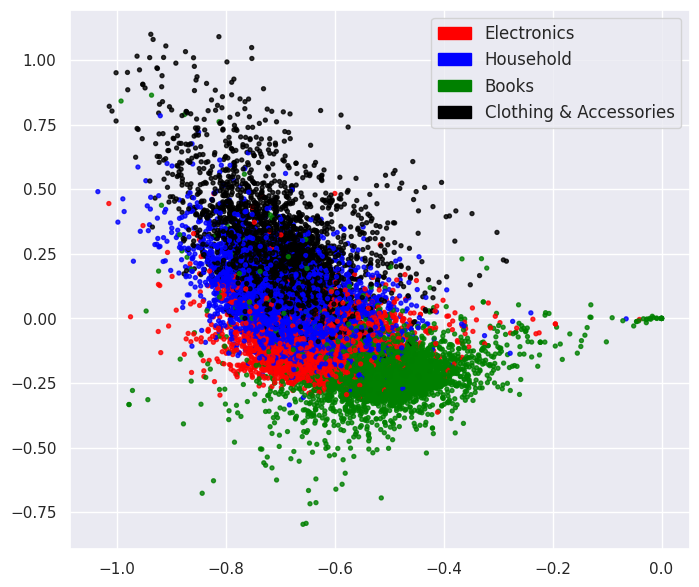

In [ ]:
# Word2Vec embedding
X_train_embed = get_word2vec_embeddings(word2vec, data_train['tokens'])
X_val_embed = get_word2vec_embeddings(word2vec, data_val['tokens'])
X_test_embed = get_word2vec_embeddings(word2vec, data_test['tokens'])

fig = plt.figure(figsize = (8, 7))
plot_embedding(X_train_embed, y_train)
plt.show()

In [ ]:
# Converting to Compressed Sparse Row matrix
X_train_w2v = scipy.sparse.csr_matrix(X_train_embed)
X_val_w2v = scipy.sparse.csr_matrix(X_val_embed)
X_test_w2v = scipy.sparse.csr_matrix(X_test_embed)

## Word2Vec Baseline Modeling

In [ ]:
# Summary of baseline models
score(X_train_w2v, y_train, X_val_w2v, y_val, names = names, models = models)

,Classifier,Training accuracy,Validation accuracy
7,XGBoost,0.999955,0.943525
3,Linear SVM,0.937233,0.934173
5,SGD Classifier,0.931163,0.930216
0,Logistic Regression,0.931613,0.928777
4,Random Forest,0.999910,0.928417
6,Ridge Classifier,0.921811,0.924820
1,KNN Classifier,0.913268,0.912590
8,AdaBoost,0.856796,0.849640
2,Decision Tree,0.999955,0.806115


## Word2Vec Hyperparameter Tuning

We perform **hyperparameter tuning** on the best performing baseline model.

In [ ]:
# Hyperparameter tuning for XGBoost
xgb = XGBClassifier()
params_xgb = {
    'learning_rate': [0.03, 0.3],
    'min_child_weight': [0, 10],
    'n_estimators': [200],
    'reg_lambda': [1, 2],
    'seed': [40]
}

best_model_xgb, best_params_xgb, best_score_xgb, count = xgb, ParameterGrid(params_xgb)[0], 0, 0
for g in ParameterGrid(params_xgb):
    time_start = time.time()
    count += 1
    print(f"Gridpoint #{count}: {g}")
    xgb.set_params(**g)
    xgb.fit(X_train_w2v, y_train)
    y_train_pred, y_val_pred = xgb.predict(X_train_w2v), xgb.predict(X_val_w2v)
    score_train, score_val = accuracy_score(y_train, y_train_pred), accuracy_score(y_val, y_val_pred)
    time_stop = time.time()
    m, s = int(time_stop - time_start) // 60, int(time_stop - time_start) % 60
    print(f"Training accuracy: {score_train}, Validation accuracy: {score_val}, Runtime: {m}m{s}s")
    print(" ")
    if score_val > best_score_xgb:
        best_params_xgb, best_score_xgb = g, score_val

best_model_w2v, best_params_w2v, best_score_w2v = XGBClassifier(), best_params_xgb, best_score_xgb
best_model_w2v.set_params(**best_params_w2v)
print(f"Best model: {best_model_w2v}")
print(" ")
print(f"Best parameters: {best_params_w2v}")
print(f"Best validation accuracy: {best_score_w2v}")

Gridpoint #1: {'learning_rate': 0.03, 'min_child_weight': 0, 'n_estimators': 200, 'reg_lambda': 1, 'seed': 40}
Training accuracy: 0.9729328717233937, Validation accuracy: 0.9316546762589928, Runtime: 2m39s
 
Gridpoint #2: {'learning_rate': 0.03, 'min_child_weight': 0, 'n_estimators': 200, 'reg_lambda': 2, 'seed': 40}
Training accuracy: 0.9718537835528978, Validation accuracy: 0.9320143884892086, Runtime: 2m34s
 
Gridpoint #3: {'learning_rate': 0.03, 'min_child_weight': 10, 'n_estimators': 200, 'reg_lambda': 1, 'seed': 40}
Training accuracy: 0.9689762150982419, Validation accuracy: 0.9309352517985612, Runtime: 2m1s
 
Gridpoint #4: {'learning_rate': 0.03, 'min_child_weight': 10, 'n_estimators': 200, 'reg_lambda': 2, 'seed': 40}
Training accuracy: 0.96794208893485, Validation accuracy: 0.9323741007194245, Runtime: 2m2s
 
Gridpoint #5: {'learning_rate': 0.3, 'min_child_weight': 0, 'n_estimators': 200, 'reg_lambda': 1, 'seed': 40}
Training accuracy: 0.999955037992896, Validation accuracy: 0

# Final Prediction and Evaluation

We employ the model with the highest validation accuracy to predict the labels of the test observations and report the resulting test accuracy and confusion matrix.

In [ ]:
# Function to compute and print confusion matrix
def conf_mat(y_test, y_test_pred, figsize = (10, 8), font_scale = 1.2, annot_kws_size = 16):
    class_names = [0, 1, 2, 3] # ['Electronics', 'Household', 'Books', 'Clothing & Accessories']
    tick_marks_y = [0.5, 1.5, 2.5, 3.5]
    tick_marks_x = [0.5, 1.5, 2.5, 3.5]
    confusion_matrix = metrics.confusion_matrix(y_test, y_test_pred)
    confusion_matrix_df = pd.DataFrame(confusion_matrix, range(4), range(4))
    plt.figure(figsize = figsize)
    sns.set(font_scale = font_scale) # label size
    plt.title("Confusion Matrix")
    sns.heatmap(confusion_matrix_df, annot = True, annot_kws = {"size": annot_kws_size}, fmt = 'd') # font size
    plt.yticks(tick_marks_y, class_names, rotation = 'vertical')
    plt.xticks(tick_marks_x, class_names, rotation = 'horizontal')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.show()

In [ ]:
Best model
if best_score_tfidf >= best_score_w2v:
    best_model, X_train_vec, X_test_vec = best_model_tfidf, X_train_tfidf, X_test_tfidf
else:
best_model, X_train_vec, X_test_vec = best_model_w2v, X_train_w2v, X_test_w2v

Test accuracy    0.940669
 


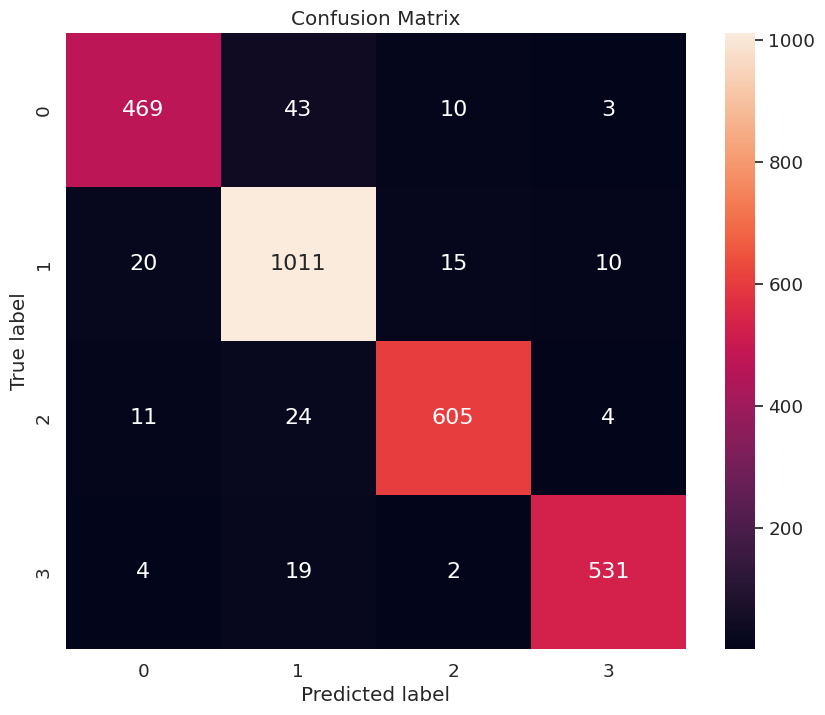

In [ ]:
# Prediction and evaluation on test set
best_model.fit(X_train_w2v, y_train)
y_test_pred = best_model.predict(X_test_vec)
score_test = accuracy_score(y_test, y_test_pred)
print(pd.Series({"Test accuracy": score_test}).to_string())
print(" ")
conf_mat(y_test, y_test_pred, figsize = (10, 8), font_scale = 1.2, annot_kws_size = 16) # Confusion matrix

In [ ]:
# Runtime and memory usage
stop = time.time()
print(pd.Series({"Process runtime": "{:.2f} seconds".format(float(stop - start)),
                 "Process memory usage": "{:.2f} MB".format(float(process.memory_info()[0]/(1024*1024)))}).to_string())

Process runtime         11844.92 seconds
Process memory usage          5903.08 MB
